# Imports

In [107]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import osmnx as ox
import geopandas as gpd
import osmium
from shapely.geometry import Polygon
import json
import fiona
import os
from shapely.geometry import shape 
import contextily as ctx
from sklearn.preprocessing import OneHotEncoder
from shapely.geometry import Point, Polygon
import folium
from zipfile import ZipFile
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
import seaborn as sns
from shapely.geometry import Point, LineString, MultiPoint
import requests
from io import BytesIO, StringIO
import contextily as ctx
from IPython.display import HTML, display, IFrame
import osmnx as ox
import osmium
from osm_runner import Runner
import regex as re
import unicodedata
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import osmnx as ox
import osmium
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive




for module in [pd, gpd]:
    print(module.__name__, module.__version__)

pandas 1.2.4
geopandas 0.9.0


# Data

In [52]:
green_areas = pd.read_csv('https://raw.githubusercontent.com/SowmyaMadala/WDL-Stage4/main/Data/Attracting%20Population/WDL_Green_Areas_Dataset_V1.txt', 
                          sep ="|", 
                          encoding ="latin-1").rename(columns = {'Number of Museums in influence area' : 'no_of_museums',
                                                                 'Number of parking lots in influence area' : 'no_of_parking_lots',
                                                                'Number of tourist attractions in influence area': 'no_of_tourist_attractions', 
                                                                'Green Zones Daily Average Demand':'gz_daily_avg_demand',
                                                                'Daily average of people in influence area': 'daily_avg_people',
                                                                'Number of buildings in influence area' : 'no_of_buildings',
                                                                'Number of families in influence area': 'no_of_families',
                                                                'Number of people resident in influence area' : 'no_of_people_resident'
                                                                })

green_areas.shape, green_areas.dtypes

((128, 14),
 Green_Zone_name               object
 no_of_museums                  int64
 no_of_parking_lots             int64
 no_of_tourist_attractions      int64
 gz_daily_avg_demand          float64
 Resident                       int64
 daily_avg_people             float64
 no_of_buildings                int64
 no_of_families                 int64
 no_of_people_resident          int64
 perc_senior_pop              float64
 perc_pop_until_19_yo         float64
 POINT_X                      float64
 POINT_Y                      float64
 dtype: object)

In [53]:
# reload preprocessed
dl_construct = 'https://drive.google.com/uc?export=download&id='
file_id1 = '1viY2xYcFe_m29i0TOATZOSAAsjnaf1Iy'
csv = requests.get(f'{dl_construct}{file_id1}').content
# url = 'https://drive.google.com/file/d/1viY2xYcFe_m29i0TOATZOSAAsjnaf1Iy/view?usp=sharing'
# csv = requests.get(url).content
mem = BytesIO(csv)
# check
df = pd.read_csv(mem, 
                index_col=0,
               )
df.shape

(64, 105)

# Creating target

In [54]:
agg = {'daily_avg_people':'sum'}
totals = green_areas.groupby('Green_Zone_name').agg(agg).rename(columns={'daily_avg_people':'total_avg_ppl'})

In [55]:
# computing the ratio btw. visitors of area
df = df.merge(totals, 
              left_on='Green_Zone_name',
             right_index=True)
df['rel_daily'] = df.daily_avg_people/df.total_avg_ppl
# computing the relative demand by residents for gz's
df['rel_demand'] = df.gz_daily_avg_demand*df.rel_daily

In [57]:
df.sample(5)

,feat_amenity_arena,feat_amenity_arts_centre,feat_amenity_auditorium,feat_amenity_bench,feat_amenity_biergarten,feat_amenity_bus_station,feat_amenity_cafe,feat_amenity_car_wash,feat_amenity_charging_station,feat_amenity_clinic,...,daily_avg_people,no_of_buildings,no_of_families,no_of_people_resident,perc_senior_pop,perc_pop_until_19_yo,Dicofre,total_avg_ppl,rel_daily,rel_demand
match,,,,,,,,,,,,,,,,,,,,,
35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,22274.016565,1553,14194,38102,0.186998,0.193139,110665,31095.929200,0.716300,1.071318
11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9928.080489,2041,4529,12701,0.104874,0.260294,110657,10419.716931,0.952817,54.441171
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17780.803014,4783,15352,38012,0.195123,0.196017,131216,63568.432312,0.279711,1.042953
94.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49448.596049,8755,36985,90176,0.173749,0.195861,110657,120652.527829,0.409843,41.798094
57.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,...,16782.664422,5428,10994,24265,0.271337,0.149062,131218,69616.791301,0.241072,69.776567


# Features

In [72]:
df.columns

Index(['feat_amenity_arena', 'feat_amenity_arts_centre',
       'feat_amenity_auditorium', 'feat_amenity_bench',
       'feat_amenity_biergarten', 'feat_amenity_bus_station',
       'feat_amenity_cafe', 'feat_amenity_car_wash',
       'feat_amenity_charging_station', 'feat_amenity_clinic',
       ...
       'daily_avg_people', 'no_of_buildings', 'no_of_families',
       'no_of_people_resident', 'perc_senior_pop', 'perc_pop_until_19_yo',
       'Dicofre', 'total_avg_ppl', 'rel_daily', 'rel_demand'],
      dtype='object', length=108)

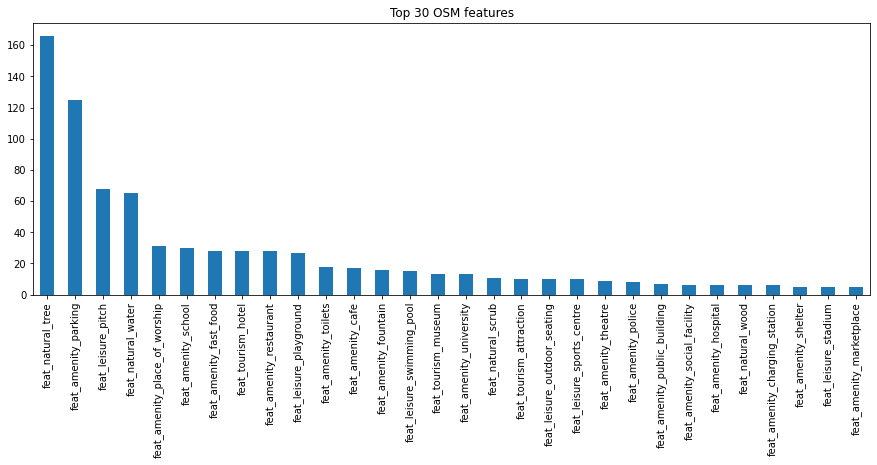

In [73]:
# plot features
osms = df[[x for x in df.columns if 'feat_' in x]].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 5))
osms.head(30).plot(kind='bar')
plt.title('Top 30 OSM features')
plt.show()

# Correlations

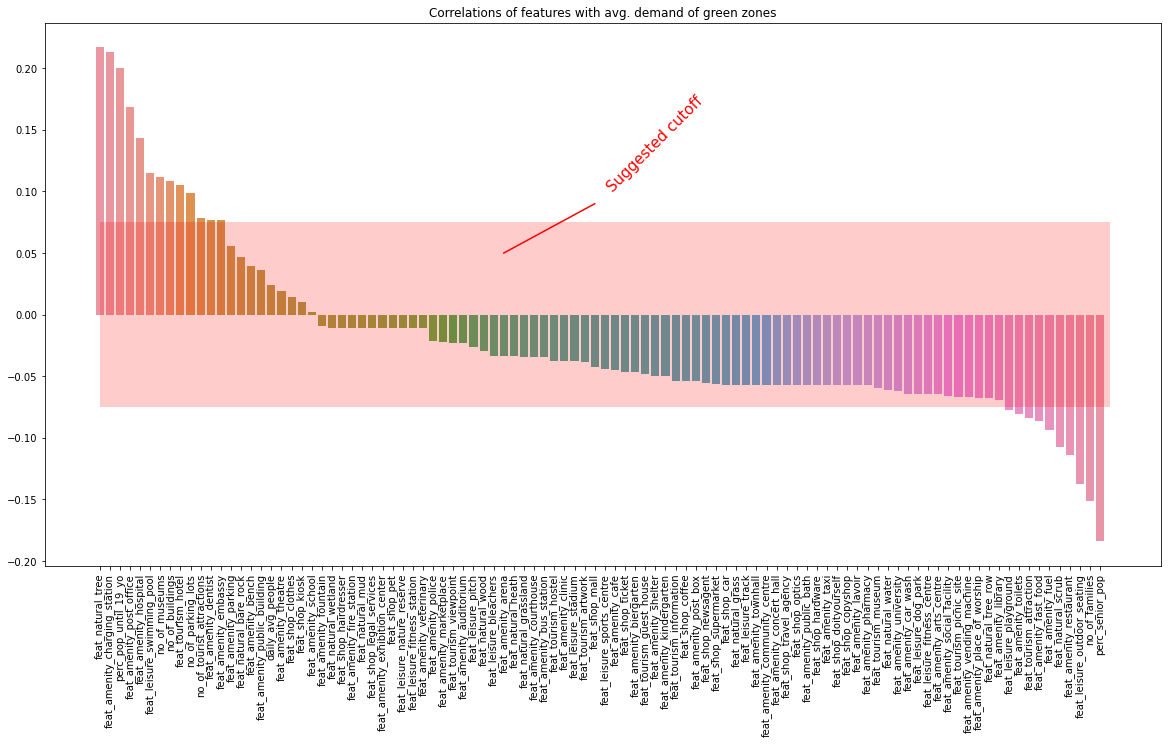

In [125]:
feats = df[[x for x in df.columns if 'feat_' in x]]
corr = df.drop(columns=['Dicofre', 
                        'total_avg_ppl', 
                        'rel_daily', 
                        'rel_demand',
                        'gz_daily_avg_demand',
                        'Resident',
                        'no_of_people_resident' # not sure bout this
                       ]).corrwith(df['rel_demand'], 
                                              axis=0).sort_values(ascending=False)
plt.figure(figsize=(20,10))
# plot
ax = sns.barplot(x=corr.keys(), y=corr)
plt.xticks(rotation=90)
# rectangle
rect = patches.Rectangle((0, -.075), 100, .15, 
                         linewidth=0,  
                         facecolor='r',
                         alpha=.2)
ax.add_patch(rect)
# text
plt.title('Correlations of features with avg. demand of green zones')
plt.text(x=50, 
         y=.10, 
         s='Suggested cutoff',
         rotation=45,
         color='r',
         size=15)

# line
plt.plot((40, 49), 
         (.05, .09),
        c='r')
plt.show()

# Selection

In [145]:
# perform cutoff
column_select = list(corr[~corr.between(-.075, .075)].keys())
column_select.append('rel_demand')

In [148]:
df_select = df[column_select].reset_index().rename(columns={'match':
                                                            'park_id'})
df_select.head(3)

,park_id,feat_natural_tree,feat_amenity_charging_station,perc_pop_until_19_yo,feat_amenity_post_office,feat_amenity_hospital,feat_leisure_swimming_pool,no_of_museums,no_of_buildings,feat_tourism_hotel,...,feat_amenity_toilets,feat_tourism_attraction,feat_amenity_fast_food,feat_amenity_fuel,feat_natural_scrub,feat_amenity_restaurant,feat_leisure_outdoor_seating,no_of_families,perc_senior_pop,rel_demand
0,0.0,0.0,0.0,0.196017,0.0,0.0,0.0,5,4783,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15352,0.195123,1.042953
1,3.0,0.0,0.0,0.204917,0.0,0.0,0.0,93,1775,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,17185,0.161747,2.973259
2,5.0,0.0,0.0,0.204917,0.0,0.0,0.0,8,1775,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17185,0.161747,13.722170
